In [70]:
# !wget https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv

In [71]:
import numpy as np
import pandas as pd

In [72]:
df = pd.read_csv("data.csv")
used_columns = [
    "Make",
    "Model",
    "Year",
    "Engine HP",
    "Engine Cylinders",
    "Transmission Type",
    "Vehicle Style",
    "highway MPG",
    "city mpg",
    "MSRP",
]
print("FULL", df.columns)
df = df[used_columns]
print("USED", df.columns)

df.columns = df.columns.str.lower().str.replace(" ", "_")
print("STANDARDIZED", df.columns)


FULL Index(['Make', 'Model', 'Year', 'Engine Fuel Type', 'Engine HP',
       'Engine Cylinders', 'Transmission Type', 'Driven_Wheels',
       'Number of Doors', 'Market Category', 'Vehicle Size', 'Vehicle Style',
       'highway MPG', 'city mpg', 'Popularity', 'MSRP'],
      dtype='object')
USED Index(['Make', 'Model', 'Year', 'Engine HP', 'Engine Cylinders',
       'Transmission Type', 'Vehicle Style', 'highway MPG', 'city mpg',
       'MSRP'],
      dtype='object')
STANDARDIZED Index(['make', 'model', 'year', 'engine_hp', 'engine_cylinders',
       'transmission_type', 'vehicle_style', 'highway_mpg', 'city_mpg',
       'msrp'],
      dtype='object')


In [73]:
print("NULL BEFORE", df.isnull().sum(), "\n")
df = df.fillna(0)
print("NULL AFTER", df.isnull().sum(), "\n")


NULL BEFORE make                  0
model                 0
year                  0
engine_hp            69
engine_cylinders     30
transmission_type     0
vehicle_style         0
highway_mpg           0
city_mpg              0
msrp                  0
dtype: int64 

NULL AFTER make                 0
model                0
year                 0
engine_hp            0
engine_cylinders     0
transmission_type    0
vehicle_style        0
highway_mpg          0
city_mpg             0
msrp                 0
dtype: int64 



In [74]:
avg_msrp = df.msrp.mean()
print("AVG price", avg_msrp)
df["above_average"] = (df.msrp >= avg_msrp).astype(int)


AVG price 40594.737032063116


In [75]:
from sklearn.model_selection import train_test_split

random_seed = 1
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=random_seed)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=random_seed)

y_train = df_train.above_average.values
y_val = df_val.above_average.values
y_test = df_test.above_average.values

del df_train["above_average"]
del df_val["above_average"]
del df_test["above_average"]


del df_train["msrp"]
del df_val["msrp"]
del df_test["msrp"]

# Removing MSRP as it's directly correlates to "above_average"
# ^^^ Also not lowercasing/replacing spaces for column values, as was not required

In [76]:
df_train.head()

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg
5727,Toyota,Highlander Hybrid,2016,280.0,6.0,AUTOMATIC,4dr SUV,28,27
5814,Chevrolet,Impala Limited,2014,300.0,6.0,AUTOMATIC,Sedan,30,18
8450,Buick,Regal,2016,259.0,4.0,AUTOMATIC,Sedan,27,19
2396,Volkswagen,CC,2015,280.0,6.0,AUTOMATED_MANUAL,Sedan,25,17
5494,Dodge,Grand Caravan,2016,283.0,6.0,AUTOMATIC,Passenger Minivan,25,17


### Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the `above_average` variable
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['engine_hp']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

In [77]:
from sklearn.metrics import roc_auc_score
# df_train.dtypes
numerical = [
    # "year", - not including year as although it's a number, 
    # it's actually a categorical feature
    "engine_hp",
    "engine_cylinders",
    "highway_mpg",
    "city_mpg",
    # "msrp",
]
for feature in numerical:
    score = df_train[feature]
    auc_below_point_five_by_default = [
        "highway_mpg",
        "city_mpg"
    ]
    if feature in auc_below_point_five_by_default:
        score = -df_train[feature]
    auc = roc_auc_score(y_train, score)
    print(
        "Feature: %s -> AUC %.3f" % (feature, auc)
    )

# Highest AUC - for "engine_hp"


Feature: engine_hp -> AUC 0.917
Feature: engine_cylinders -> AUC 0.766
Feature: highway_mpg -> AUC 0.633
Feature: city_mpg -> AUC 0.673


### Question 2: Training the model

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```python
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

What's the AUC of this model on the validation dataset? (round to 3 digits)

In [78]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer

train_dicts = df_train.to_dict(orient="records")
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)


val_dicts = df_val.to_dict(orient="records")
X_val = dv.transform(val_dicts)
y_pred = model.predict_proba(X_val)[:, 1]

auc = roc_auc_score(y_val, y_pred)
print("%.3f" % auc)

# AUC for the validation dataset on this model is 0.980 (with 4 digits - 0.9797)

0.980


### Question 3: Precision and Recall

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

At which threshold precision and recall curves intersect?


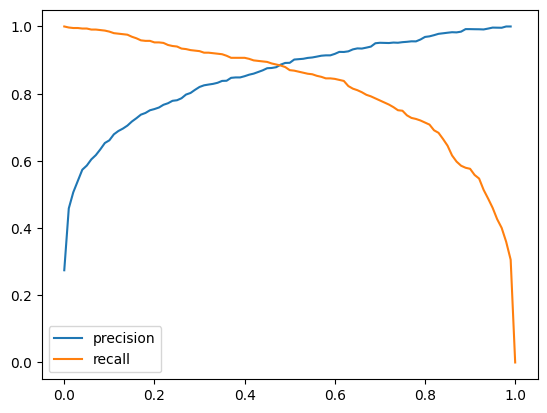

In [79]:
import matplotlib.pyplot as plt

thresholds = np.arange(0.0, 1.01, 0.01)
def get_confusion_dataframe(y_val, y_pred, thresholds):
    scores = []
    precisions = []
    recalls = []
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    for t in thresholds:
        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        true_negative = (predict_negative & actual_negative).sum()
        false_positive = (predict_positive & actual_negative).sum()
        false_negative = (predict_negative & actual_positive).sum()
        true_positive = (predict_positive & actual_positive).sum()
        
        scores.append((t, true_positive, false_positive, false_negative, true_negative))
    columns = ["threshold", "tp", "fp", "fn", "tn"]
    df_scores = pd.DataFrame(scores, columns=columns)
    return df_scores

df_scores = get_confusion_dataframe(y_val, y_pred, thresholds)
df_scores.columns
df_scores["p"] = df_scores["tp"] / (df_scores["tp"] + df_scores.fp)
df_scores["r"] = df_scores.tp / (df_scores.tp + df_scores.fn)
plt.plot(df_scores.threshold, df_scores.p, label="precision")
plt.plot(df_scores.threshold, df_scores.r, label="recall")

plt.legend()

# The intersection is at around 0.48

### Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

49    0.49
Name: threshold, dtype: float64


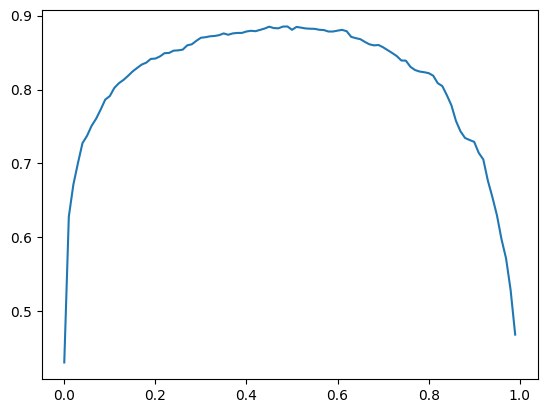

In [80]:
df_scores["f"] = 2 * ((df_scores.p * df_scores.r) / (df_scores.p+df_scores.r))
plt.plot(thresholds, df_scores.f)

max_f_threshold = df_scores[df_scores.f.max() == df_scores.f].threshold
print(max_f_threshold)

# F1 is maximal at threshold 0.49


### Question 5: 5-Fold CV


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```python
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation

How large is standard devidation of the scores across different folds?

In [81]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
scores = []
for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.above_average.values
    y_val = df_val.above_average.values

    del df_train["above_average"]
    del df_val["above_average"]

    del df_train["msrp"]
    del df_val["msrp"]

    train_dicts = df_train.to_dict(orient="records")
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(train_dicts)

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)

    val_dicts = df_val.to_dict(orient="records")
    X_val = dv.transform(val_dicts)

    y_pred = model.predict_proba(X_val)[:, 1]

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)
print("%.3f += %.3f" % (np.mean(scores), np.std(scores)))

# Scores standard deviation is 0.002


0.979 += 0.002


### Question 6: Hyperparemeter Tuning

Now let's use 5-Fold cross-validation to find the best parameter `C`

* Iterate over the following `C` values: `[0.01, 0.1, 0.5, 10]`
* Initialize `KFold` with the same parameters as previously
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which `C` leads to the best mean score?

In [82]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for C in [0.01, 0.1, 0.5, 10]:
    scores = []
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.above_average.values
        y_val = df_val.above_average.values

        del df_train["above_average"]
        del df_val["above_average"]

        del df_train["msrp"]
        del df_val["msrp"]

        train_dicts = df_train.to_dict(orient="records")
        dv = DictVectorizer(sparse=False)
        X_train = dv.fit_transform(train_dicts)

        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train, y_train)

        val_dicts = df_val.to_dict(orient="records")
        X_val = dv.transform(val_dicts)

        y_pred = model.predict_proba(X_val)[:, 1]

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
    print("%s %.3f += %.3f" % (C, np.mean(scores), np.std(scores)))

# C=10 leads to the best AUC mean score (0.981)

0.01 0.952 += 0.003
0.1 0.972 += 0.002
0.5 0.977 += 0.002
10 0.981 += 0.003
